# CNN training on various images with optional additional feature vectors

In [1]:
import os
import sys
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable, Tuple, List
import tensorflow as tf
if not tf.config.list_physical_devices('GPU'):
    print('Warning: without a GPU the training will take a long time...')


In [2]:
# Constants
IMAGE_SIZE = (256, 256, 3)
NUM_CLASSES = 125
# SKETCH_ROOT = '/Users/taehun.kim/mids/rendered_256x256/256x256/sketch'
SKETCH_ROOT = r'D:\Documents\MIDS\W281\2023-mids-w81-final-project-dataset\256x256\sketch'
assert os.path.isdir(SKETCH_ROOT)

## Load dataset

### Load image-only dataset

In [3]:
def get_image_dataset(ratios: List[float], augmentations: List[str] = None, color_mode: str = 'rgb',
                    seed: int = 1, batch_size: int = 32) -> List[tf.data.Dataset]:
    '''
    Get tensorflow dataset using generator to avoid RAM limitations
    Splits into train, val, test from all provided augmentations 
    '''

    # No augmentation by default
    augmentations = augmentations or ['tx_000100000000']

    assert sum(ratios) == 1 and len(ratios) == 3, 'Sum of 3 ratios must add to 1'

    datasets: List[List[tf.data.Dataset]] = []
    for aug in augmentations:
        print(f'Reading images from augmentation {aug}...')
        train_ds = tf.keras.utils.image_dataset_from_directory(
            directory = os.path.join(SKETCH_ROOT, aug),
            image_size = IMAGE_SIZE[:2],
            label_mode='categorical',
            seed = seed,
            color_mode = color_mode,
            validation_split = (1 - ratios[0]),
            subset = 'training',
            batch_size=batch_size
        )

        val_ds = tf.keras.utils.image_dataset_from_directory(
            directory = os.path.join(SKETCH_ROOT, aug),
            image_size = IMAGE_SIZE[:2],
            label_mode='categorical',
            seed = seed,
            color_mode = 'rgb',
            validation_split = (1 - ratios[0]),
            subset = 'validation',
            batch_size=batch_size
        )

        val_batch_count = int(tf.data.experimental.cardinality(val_ds))
        test_ds = val_ds.take(int(val_batch_count * ratios[1]))
        val_ds = val_ds.skip(int(val_batch_count * ratios[1]))

        datasets.append([train_ds, val_ds, test_ds])
    
    combined = datasets.pop()
    for train, val, test in datasets:
        combined[0] = combined[0].concatenate(train)
        combined[1] = combined[1].concatenate(val)
        combined[2] = combined[2].concatenate(test)

    return combined

In [4]:
train_ds, val_ds, test_ds = get_image_dataset([0.8, 0.1, 0.1], augmentations=['tx_000100000000'])

Reading images from augmentation tx_000100000000...
Found 75481 files belonging to 125 classes.
Using 60385 files for training.
Found 75481 files belonging to 125 classes.
Using 15096 files for validation.


### Load Image dataset with additional numerical features

In [29]:
def get_image_dataset_w_feature(features: np.ndarray, ratios: List[float], augmentation: str = None, 
                                seed: int = 1, batch_size: int = 32) -> List[tf.data.Dataset]:
    '''
    Get tensorflow dataset using generator to avoid RAM limitations
    Splits into train, val, test from all provided augmentations 
    '''

    # Use centered images by default
    print('Loading images...')
    augmentation = augmentation or 'tx_000100000000'
    img_ds = tf.keras.utils.image_dataset_from_directory(
        directory = os.path.join(SKETCH_ROOT, augmentation),
        image_size = IMAGE_SIZE[:2],
        seed = seed,
        color_mode = 'rgb',
        # Don't batch as we want to batch later with others
        batch_size = None,
        # Don't shuffle as we want to shuffle later with others
        shuffle=False 
    )
    
    print('Loading feature vector...')
    hog_ds = tf.data.Dataset.from_tensor_slices(features)
    num_rows = len(hog_ds)

    num_classes = len(img_ds.class_names)

    def reorder(img, hog):
        img, label = img
        return (img, hog), tf.one_hot(label, num_classes)

    combined = tf.data.Dataset.zip((img_ds, hog_ds)).map(reorder)
    shuffled = combined.shuffle(buffer_size=num_rows, seed=seed).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    batch_count = len(shuffled)

    split = []
    for ratio in ratios:
        slice_count = int(batch_count * ratio)
        slice = shuffled.take(slice_count)
        shuffled = shuffled.skip(slice_count)
        split.append(slice)
    
    return split

In [30]:
HOG_INPUT_SIZE = 2048

# Get image + hog dataset
train_ds, val_ds, test_ds = get_image_dataset_w_feature(
    features=np.load(r'D:\Documents\MIDS\W281\2023-mids-w81-final-project-dataset\256x256\features\hog\hog_features.npz')['arr_0'],
    ratios=[0.8, 0.1, 0.1]
)
val_ds = val_ds.cache()
test_ds = test_ds.cache()

Loading images...
Found 75481 files belonging to 125 classes.
Loading feature vector...


## Build CNN model(s)

In [5]:
def _build_resnet_layers():
    pretrained_resnet = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=IMAGE_SIZE,
        pooling='avg',
        classes=NUM_CLASSES,
    )
    pretrained_resnet.trainable = False

    tf.keras.backend.clear_session()
    layer = tf.keras.layers.Dense(1024, activation='relu')(pretrained_resnet.output)
    layer = tf.keras.layers.Dense(512, activation='relu')(layer)
    return pretrained_resnet.input, layer

def _build_vgg_layer():
    pretrained_vgg = tf.keras.applications.vgg16.VGG16(
        include_top=False,
        input_shape=IMAGE_SIZE,
        pooling='avg',
        classes=NUM_CLASSES,
    )
    pretrained_vgg.trainable = False

    tf.keras.backend.clear_session()
    layer = tf.keras.layers.Dense(1024, activation='relu')(pretrained_vgg.output)
    layer = tf.keras.layers.Dense(512, activation='relu')(layer)
    return pretrained_vgg.input, layer

def _build_sketch_a_net_layers():
    # Input layer
    inputs = tf.keras.layers.Input(shape=IMAGE_SIZE, name='img_input')
    
    # Convolutional Layer 1
    conv1 = tf.keras.layers.Conv2D(64, (15, 15), activation='relu', padding='valid')(inputs)
    maxpool1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same')(conv1)
    
    # Convolutional Layer 2
    conv2 = tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='valid')(maxpool1)
    maxpool2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same')(conv2)
    
    # Convolutional Layer 3
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='valid')(maxpool2)
    
    # Convolutional Layer 4
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='valid')(conv3)
    
    # Convolutional Layer 5
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='valid')(conv4)
    maxpool5 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(3, 3), padding='same')(conv5)
    
    # Flatten
    flatten = tf.keras.layers.Flatten()(maxpool5)
    
    # Fully Connected Layers
    dense1 = tf.keras.layers.Dense(1024, activation='relu')(flatten)
    dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
    dense2 = tf.keras.layers.Dense(512, activation='relu')(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
    return inputs, dropout2

def build_naive_sketch_a_net():
    cnn_input, cnn_output = _build_sketch_a_net_layers()
    
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(cnn_output)
    return tf.keras.Model(cnn_input, outputs)

def build_naive_resnet():
    cnn_input, cnn_output = _build_resnet_layers()
    
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(cnn_output)
    return tf.keras.Model(cnn_input, outputs)

def build_naive_vgg():
    cnn_input, cnn_output = _build_vgg_layer()
    
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(cnn_output)
    return tf.keras.Model(cnn_input, outputs)

def build_cnn_with_feature(feature_vector_len: int):
    cnn_input, cnn_output = _build_resnet_layers()

    vector_shape = (feature_vector_len)
    vector_input = tf.keras.layers.Input(shape=vector_shape, name='hog_input')

    combined_output = tf.keras.layers.Concatenate()([cnn_output, vector_input])
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(combined_output)
    return tf.keras.Model(inputs=[cnn_input, vector_input], outputs=outputs)

In [6]:
model = build_naive_vgg()

In [6]:
model = build_cnn_with_feature(HOG_INPUT_SIZE)

In [7]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Perform training

In [8]:
# Reduce training size on non-powerful machines
reduce_training_size = False
actual_train_ds = train_ds.take(tf.data.experimental.cardinality(train_ds) // 100) if reduce_training_size else train_ds

epochs = 10
history = model.fit(
  actual_train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
1887/1887 [==============================] - 557s 227ms/step - loss: 2.5821 - accuracy: 0.3788 - val_loss: 1.7785 - val_accuracy: 0.5234
Epoch 2/10
1887/1887 [==============================] - 613s 262ms/step - loss: 1.7516 - accuracy: 0.5277 - val_loss: 1.4435 - val_accuracy: 0.6062
Epoch 3/10
1887/1887 [==============================] - 722s 308ms/step - loss: 1.4807 - accuracy: 0.5845 - val_loss: 1.2431 - val_accuracy: 0.6438
Epoch 4/10
1887/1887 [==============================] - 800s 317ms/step - loss: 1.3065 - accuracy: 0.6233 - val_loss: 1.0800 - val_accuracy: 0.6843
Epoch 5/10
1887/1887 [==============================] - 864s 344ms/step - loss: 1.1662 - accuracy: 0.6559 - val_loss: 1.0112 - val_accuracy: 0.6952
Epoch 6/10
1887/1887 [==============================] - 1116s 398ms/step - loss: 1.0565 - accuracy: 0.6834 - val_loss: 0.8770 - val_accuracy: 0.7460
Epoch 7/10
1887/1887 [==============================] - 1082s 427ms/step - loss: 0.9648 - accuracy: 0.7085 - va

In [8]:
def plot_results(history, show_plot: bool = True):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    # Retrieve the training metrics (after each train epoch) and the final test accuracy.
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    ax1.set_title('Accuracy')
    ax1.plot(train_accuracy, label='train_accuracy')
    ax1.plot(val_accuracy, label='validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.set_title('Loss')
    ax2.plot(train_loss, label='train loss')
    ax2.plot(val_loss, label='validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()

    if show_plot:
        plt.show()

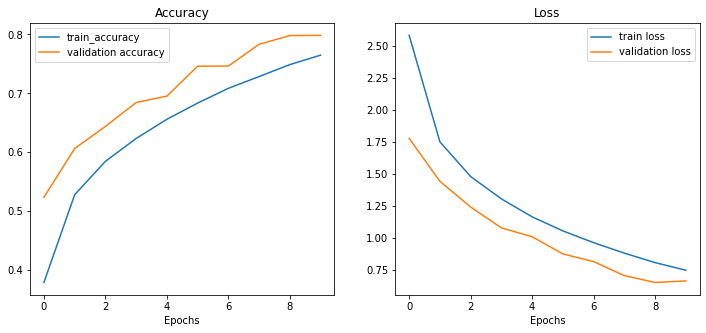

In [10]:
plot_results(history)

## Automate saving experiment results

In [9]:
# Run and save experiment

from typing import Any

RESULTS_ROOT = r'D:\Documents\MIDS\W281\2023-mids-w281-final-project\results'

def run_and_save_experiment(name: str, 
                            model: Any,
                            train_ds: tf.data.Dataset,
                            val_ds: tf.data.Dataset,
                            reduce_training_size: bool = False):
    
    experiment_dir = os.path.join(RESULTS_ROOT, name)
    os.makedirs(experiment_dir, exist_ok=True)

    actual_train_ds = train_ds.take(tf.data.experimental.cardinality(train_ds) // 100) if reduce_training_size else train_ds

    epochs = 10
    history = model.fit(
        actual_train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )

    model.save_weights(os.path.join(experiment_dir, f'{name}_model_weights.h5'))

    plot_results(history, show_plot=False)
    plt.savefig(os.path.join(experiment_dir, f'{name}_history.png'))

    with open(os.path.join(experiment_dir, f'{name}_model_summary.txt'), 'w') as f:
        f.write(f'\nTraining accuracy: {max(history.history["accuracy"])}')
        f.write(f'\nValidation accuracy: {max(history.history["val_accuracy"])}')
    

Epoch 1/10
1888/1888 [==============================] - 375s 196ms/step - loss: 1.9960 - accuracy: 0.4983 - val_loss: 1.5484 - val_accuracy: 0.5916
Epoch 2/10
1888/1888 [==============================] - 374s 198ms/step - loss: 1.3205 - accuracy: 0.6409 - val_loss: 1.4429 - val_accuracy: 0.6261
Epoch 3/10
1888/1888 [==============================] - 375s 198ms/step - loss: 1.0877 - accuracy: 0.6965 - val_loss: 1.4537 - val_accuracy: 0.6344
Epoch 4/10
1888/1888 [==============================] - 369s 195ms/step - loss: 0.9210 - accuracy: 0.7379 - val_loss: 1.4555 - val_accuracy: 0.6491
Epoch 5/10
1888/1888 [==============================] - 361s 191ms/step - loss: 0.7932 - accuracy: 0.7678 - val_loss: 1.5448 - val_accuracy: 0.6495


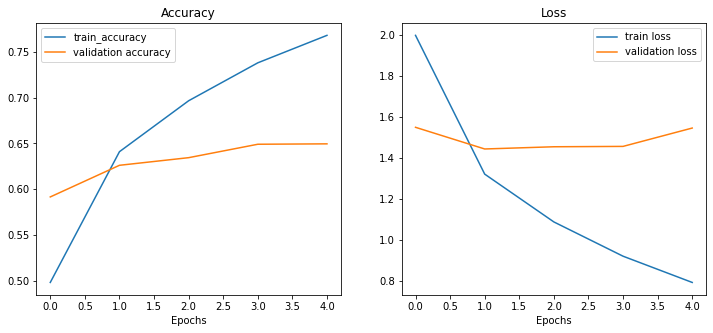

In [10]:
run_and_save_experiment('naive_vgg_tx_000100000000', model, train_ds, val_ds)

## Load model weights and perform evaluation on test set

In [8]:
model.load_weights(r'D:\Documents\MIDS\W281\2023-mids-w281-final-project\results\img_hog_resnet_tx_000100000000-2\img_hog_resnet_tx_000100000000-2_model_weights.h5')

In [16]:
test_loss, test_acc = model.evaluate(test_ds)
print(test_acc)
predictions = model.predict(test_ds)

235/235 [==============================] - 23s 97ms/step - loss: 0.3033 - accuracy: 0.9140
0.9139627814292908
235/235 [==============================] - 22s 94ms/step


In [21]:
from collections import defaultdict

class_names = os.listdir(r'D:\Documents\MIDS\W281\2023-mids-w81-final-project-dataset\256x256\sketch\tx_000100000000')

def unbatch_labels(ds: tf.data.Dataset):
    for batch in ds:
        input, label = batch
        img, hog = input
        yield from zip(img.numpy(), label.numpy())

def is_prediction_correct(prediction: np.ndarray, label: np.ndarray):
    return np.argmax(prediction) == np.argmax(label)

def group_and_sort_by_prediction_result(predictions, test_ds, correct: bool = False):
    grouped = defaultdict(list)

    for prediction, (input, label) in zip(predictions, unbatch_labels(test_ds)):
        if correct == is_prediction_correct(prediction, label):
            class_as_number = np.argmax(label)
            class_name = class_names[class_as_number]
            grouped[class_name].append((prediction, input))

    return sorted([(k, v) for k, v in grouped.items()], key= lambda kv: len(kv[1]), reverse=True)    

In [22]:
worst_categories = group_and_sort_by_prediction_result(predictions, test_ds, correct=False)
best_categories = group_and_sort_by_prediction_result(predictions, test_ds, correct=True)

In [23]:
print(f'5 Worst performing categories: {[(k, len(v)) for k, v in worst_categories][:5]}')
print(f'5 Best performing categories: {[(k, len(v)) for k, v in best_categories][:5]}')

5 Worst performing categories: [('owl', 26), ('pig', 26), ('dog', 25), ('cat', 22), ('seal', 21)]
5 Best performing categories: [('helicopter', 87), ('tiger', 85), ('raccoon', 83), ('horse', 81), ('sailboat', 77)]


In [24]:
def plot_predictions(label: str, pred_and_imgs: List[Tuple[np.ndarray, np.ndarray]], correct: bool):
    # Only plot the first 3
    pred_and_imgs = pred_and_imgs[:3]

    # create the figure and axes
    fig, axs = plt.subplots(nrows=len(pred_and_imgs), ncols=2, figsize=(10, 5 * len(pred_and_imgs)))

    # iterate over the data and plot each tuple
    for i, (prob, img) in enumerate(pred_and_imgs):
        
        # plot the image
        axs[i, 0].imshow(img)
        axs[i, 0].axis('off')

        # plot the top 5 categories as a bar graph
        top5_idx = np.argsort(prob)[::-1][:5]
        top5_prob = prob[top5_idx]
        top5_labels = [class_names[i] for i in top5_idx]
        axs[i, 1].bar(top5_labels, top5_prob)
        axs[i, 1].set_ylim([0, 1])

    # set the title and show the plot
    prefix = 'Correctly' if correct else 'Incorrectly'
    fig.suptitle(f'{prefix} predicted images for {label}', fontsize=20)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


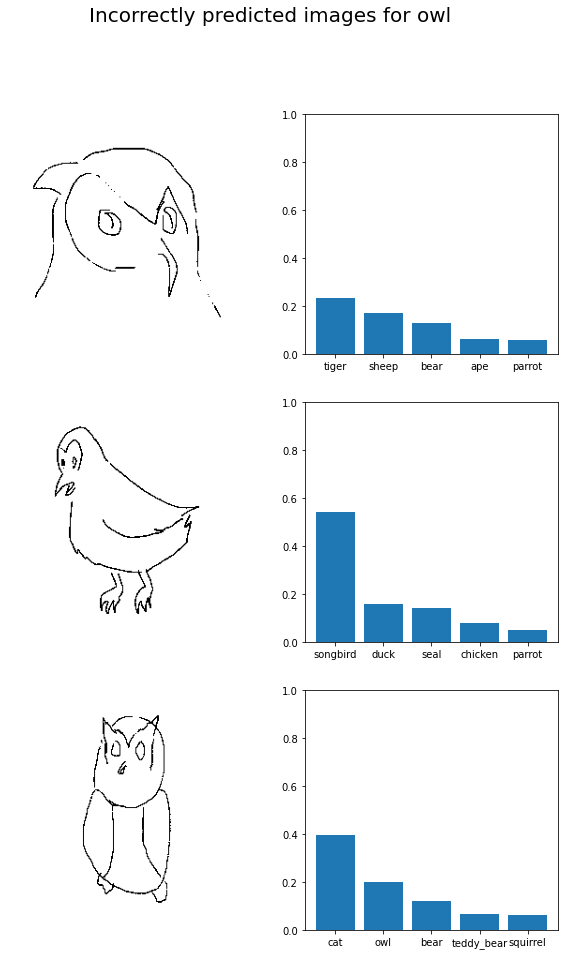

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


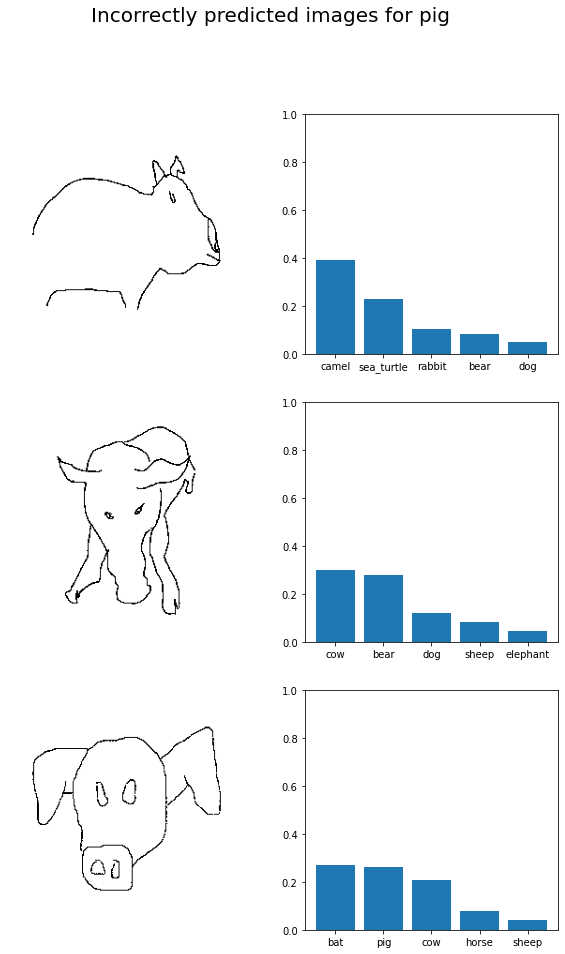

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


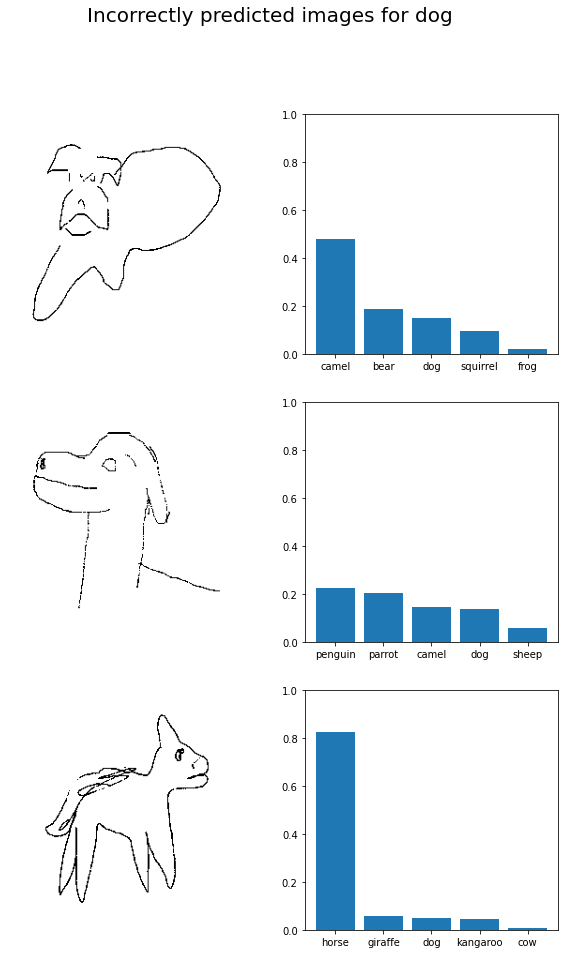

In [27]:
for label, pred_and_imgs in worst_categories[:3]:
    plot_predictions(label, pred_and_imgs, correct=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


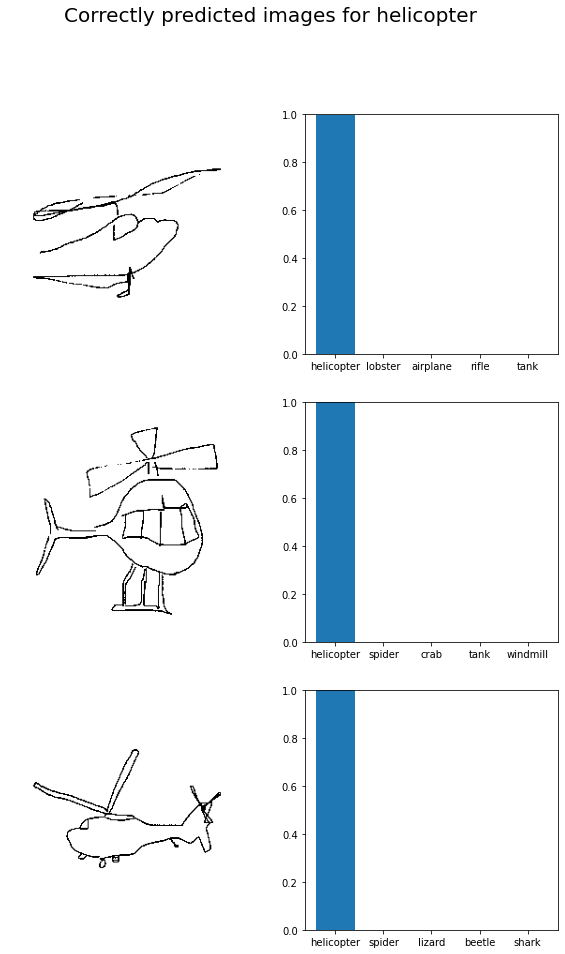

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


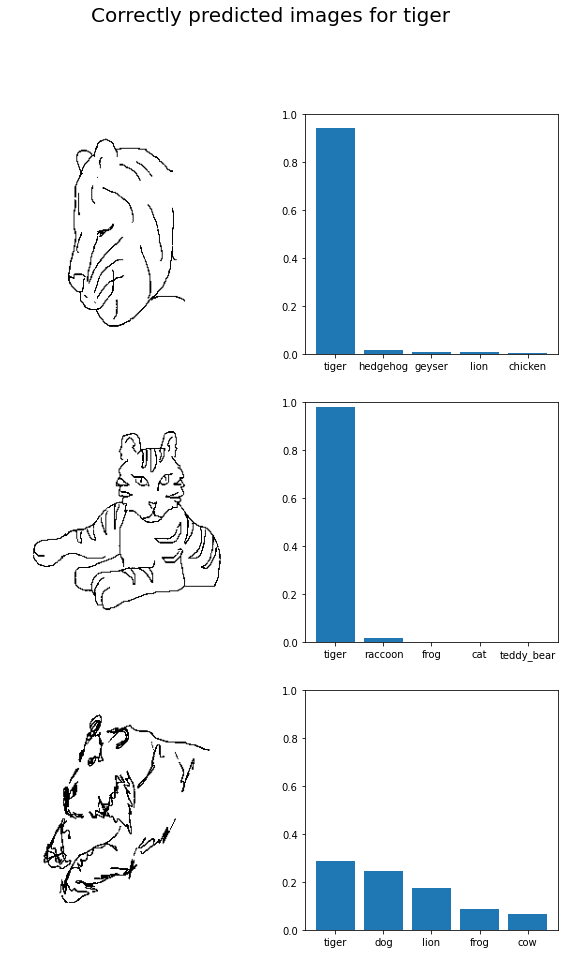

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


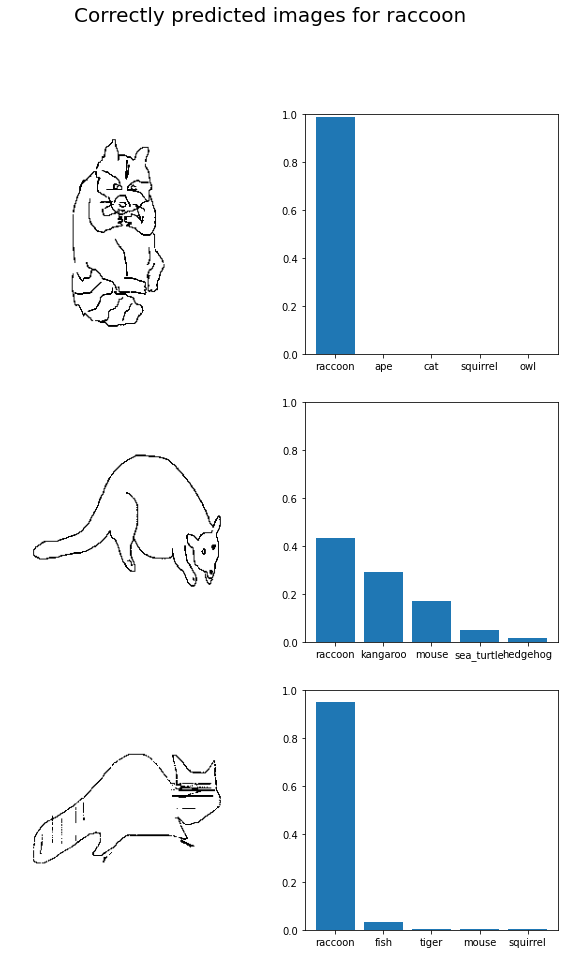

In [28]:
for label, pred_and_imgs in best_categories[:3]:
    plot_predictions(label, pred_and_imgs, correct=True)

### Live demo

In [39]:
from skimage.feature import hog

def hog_as_vector(sketch_img_fp):
    sketch_img = cv2.imread(sketch_img_fp)
    gray = cv2.cvtColor(sketch_img, cv2.COLOR_BGR2GRAY)

    feature_vector = hog(
        gray, 
        orientations = 8, 
        pixels_per_cell = (16, 16),
        cells_per_block = (1, 1), 
        visualize = False,
        feature_vector=True
    )
    return feature_vector

def predict_and_plot(model, img_fp: str) -> np.ndarray:

    # Apply feature extraction
    hog_feature = hog_as_vector(img_fp)
    hog_ds = tf.data.Dataset.from_tensor_slices([hog_feature])

    # Package image as image dataset
    img_ds = tf.keras.utils.image_dataset_from_directory(os.path.dirname(img_fp), 
        label_mode=None,
        image_size=IMAGE_SIZE[:2],
        batch_size=None)
    
    # Package both as tf.data.Dataset
    def add_dummy_label(img, hog):
        return (img, hog), [0] * NUM_CLASSES
    input_ds = tf.data.Dataset.zip((img_ds, hog_ds)).map(add_dummy_label).batch(1)

    prediction = model.predict(input_ds)[0]
    
    # create the figure and axes
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # plot the image
    axs[0].imshow(cv2.imread(img_fp))
    axs[0].axis('off')

    # plot the top 5 categories as a bar graph
    top5_idx = np.argsort(prediction)[::-1][:5]
    top5_prob = prediction[top5_idx]
    top5_labels = [class_names[i] for i in top5_idx]
    axs[1].bar(top5_labels, top5_prob)
    axs[1].set_ylim([0, 1])

    fig.suptitle(f'Top 5 predictions for {img_fp}', fontsize=20)
    plt.show()

Found 1 files belonging to 1 classes.
1/1 [==============================] - 0s 35ms/step


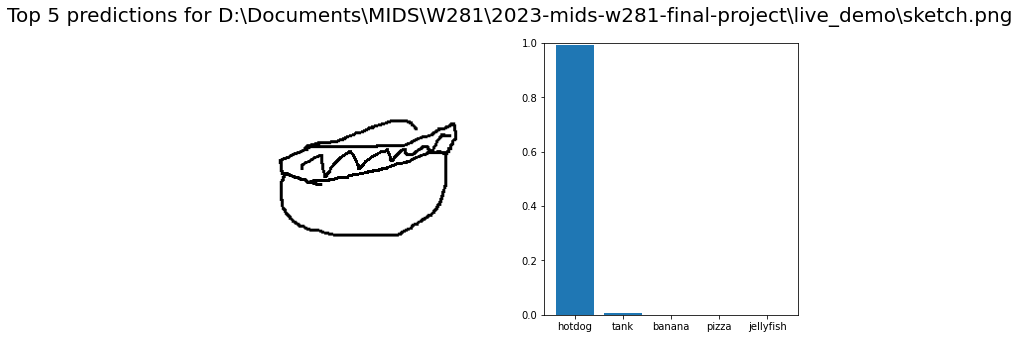

In [58]:
img_fp = r'D:\Documents\MIDS\W281\2023-mids-w281-final-project\live_demo\sketch.png'
predict_and_plot(model, img_fp)